# Convolutional Neural Networks for Sentence Classification

This Jupyter notebook attempts to replicate results from the paper _Kim, Yoon. "Convolutional neural networks for sentence classification." arXiv preprint arXiv:1408.5882 (2014)._. It uses convolutional neural networks to classify sentences.

The implementation is done using PyTorch 1.1 on Python 3.7. I will try to restrict using other packages to keep the implementation barebones. The following packages are needed as part of the pipeline.

* `torch`
* `torchtext`
* `numpy`
* `spacy`
* `mlogger`
* `fastprogress`
* `livelossplot`

In [0]:
# Install necessary packages for Google Colab
%%capture magic
!pip install torchtext mlogger fastprogress livelossplot spacy
!python -m spacy download en

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

import torchtext
import mlogger
from fastprogress import master_bar, progress_bar
from pathlib import Path
from livelossplot import PlotLosses
import numpy as np

### Model Definition

The TextCNN model consists of a convolutional neural network with three varying kernel sizes. The kernel is non-square of dimensions (`kernel_height`, `embedding_dim`), where `embedding_dim` is the size of the word vectors. Each convolutional layer uses a ReLu activation layer followed by maxpooling along the primary dimension. The maxpooled tensors are then concatenated and fed through a linear layer.

In [0]:
class TextCNN(nn.Module):
    """Implements text classification using CNNs
    
    A text classification model in PyTorch using Convolutional Neural Networks.
    The model consists of three kernels of size (kernel_height, embedding_dim)
    where the kernel heights are generally [3, 4, 5].
    
    Arguments
        config (dict): a configuration dictionary for model parameters
            (default None)
            
            The configuration object expects a minimum of the following
            arguments
            
                vocab_size: number of words in vocabulary
                embeddimg_dim: size of word vectors
                weights: word vector embeddings
                in_channels: number of channels in image (for text, set as 1)
                out_channels: number of feature maps to create (a sensible
                    default is 128)
                kernel_sizes: default kernel sizes should [3, 4, 5]
                keep_prob: keep probability for the dropout layer
                output_size: number of output_classes
    """
    
    def __init__(self, config):
        
        super(TextCNN, self).__init__()
        
        # Parameters for Embedding Layer
        self.vocab_size = config['vocab_size']
        self.embedding_dim = config['embedding_dim']
        self.weights = config['weights']
        
        # Parameters for Convolutional Layers
        self.in_channels = config['in_channels']
        self.out_channels = config['out_channels']
        self.kernel_sizes = config['kernel_sizes']
        
        # Parameters for Dropout Layer
        self.keep_prob = config['keep_prob']
        
        # Parameters for Output Layer
        self.output_size = config['output_size']
        
        # Layer Definitions
        self.embed = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embed.weights = nn.Parameter(self.weights, requires_grad=False)
        self.conv1 = nn.Conv2d(self.in_channels, self.out_channels, 
                               (self.kernel_sizes[0], self.embedding_dim))
        self.conv2 = nn.Conv2d(self.in_channels, self.out_channels, 
                               (self.kernel_sizes[1], self.embedding_dim))
        self.conv3 = nn.Conv2d(self.in_channels, self.out_channels, 
                               (self.kernel_sizes[2], self.embedding_dim))
        self.dropout = nn.Dropout(self.keep_prob)
        self.linear = nn.Linear(len(self.kernel_sizes) * self.out_channels, 
                                self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.embed(x) # x is of shape (batch_size, num_seq, embedding_dim)
        x = x.unsqueeze(1) # x is of shape (batch_size, in_channel, num_seq, embedding_dim)
        
        # conv will create tensor of size (batch_size, out_channels, num_seq-2, 1)
        activation1 = F.relu(self.conv1(x).squeeze(3))
        activation2 = F.relu(self.conv2(x).squeeze(3))
        activation3 = F.relu(self.conv3(x).squeeze(3))
        
        out1 = F.max_pool1d(activation1, activation1.size()[2])
        out2 = F.max_pool1d(activation1, activation2.size()[2])
        out3 = F.max_pool1d(activation1, activation3.size()[2])
        
        out = torch.cat((out1, out2, out3), 1).squeeze(2) # out is of size (batch_size, num_kernels*output_channels)
        out = self.linear(out)
        
        logits = self.dropout(out)
        label = self.softmax(logits)
        
        return (label, logits)

In [0]:
def save_model(config, model, optimizer, loss, epoch, is_best, save_dir):
    """Save model to disk
    
    Arguments
        config: configuration dictionary of model parameters
        model: the model instance that is being saved
        optimizer: the optimizer instance
        loss: the validation loss
        epoch: epoch number
        is_best: is it the best epoch so far
        save_dir: path to save directory
    """
    path = Path(save_dir)
    
    checkpoint = path / f"model_{epoch}.pt"
    latest = path / "model_latest.pt"
    best = path / "model_best.pt"
    
    state_dict = {
        'config': config,
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    
    torch.save(state_dict, checkpoint)
    torch.save(state_dict, latest)
    if is_best:
        torch.save(state_dict, best)
        

def load_model(path):
    """Load model from disk
    
    Arguments
        path: path to the checkpoint file
    """
    
    checkpoint = torch.load(path)
    
    # Get config and instantiate model
    config = checkpoint['config']
    model = TextCNN(config)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Instantiate optimizer
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, 
                                        model.parameters()))
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Epoch
    epoch = checkpoint['epoch']
    
    return config, model, optimizer, epoch


def load_best_model(save_dir):
    """Load best model from the save directory
    
    Arguments
        save_dir: path to the save directory
    """
    
    best_model_path = Path(save_dir) / "model_best.pt"
    return load_model(best_model_path)

### Data Loading

PyTorch supplies a utility library for data loading specific to NLP -- `torchtext`. I want to use the IMDb dataset to tag reviews as positive or negative. 

The first step to create a data loading pipeline is to define the fields in the dataset. In our case, we only have two fields -- text and label. The text must subsequently be lower-cased, tokenized, and transformed to respective indices. Futhermore, we want to limit the length of each text field to a fixed number of words. I set this to 100 words.

In [5]:
# Define fields from TorchText
TEXT = torchtext.data.Field(sequential=True, tokenize='spacy', 
                            include_lengths=True, fix_length=200, 
                            batch_first=True)
LABEL = torchtext.data.LabelField()

# Load dataset (IMDB)
_train_data, _test_data = torchtext.datasets.IMDB.splits(TEXT, LABEL)

# Build Vectors
vectors = torchtext.vocab.GloVe(name='6B')
TEXT.build_vocab(_train_data, vectors=vectors)
LABEL.build_vocab(_train_data)
word_embeddings = TEXT.vocab.vectors

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:07<00:00, 10.9MB/s]
.vector_cache/glove.6B.zip: 862MB [01:01, 14.0MB/s]                           
100%|█████████▉| 399906/400000 [00:52<00:00, 7798.23it/s]

Let's check the size of the vocabulary and the number of labels, just to be sure.

In [6]:
print ("Length of Text Vocabulary: " + str(len(TEXT.vocab)))
print ("Vector size of Text Vocabulary: ", TEXT.vocab.vectors.size())
print ("Label Length: " + str(len(LABEL.vocab)))

Length of Text Vocabulary: 121881
Vector size of Text Vocabulary:  torch.Size([121881, 300])
Label Length: 2


### Bucketing Data into Train, Test, and Validation

An important step in any machine learning is to split the dataset into train, test, and validation. The dataset we loaded already came split into train and test. We only want to split the training set into train and validation.

Finally, we create `BucketIterator` objects that yield batches for train, test, and validation. Here, we set the batch size to 32. If your GPU is large enough, you can increast the batch size to 64 or even 128.

In [0]:
train_data = _train_data
test_data = _test_data

# Split train data into train and validation
train_data, valid_data = train_data.split(split_ratio=0.7)
train_iter, valid_iter, test_iter = torchtext.data.BucketIterator.splits((train_data, valid_data, test_data), 
                                                                         batch_size=32, shuffle=True, repeat=False)
vocab_size = len(TEXT.vocab)

### Model Training

The first step of training is to define three things:
* the model
* the loss function
* the optimizer

The model we create is an instantiation of the `TextCNN` model from the configuration object. The loss function (AKA criterion) is set up as an Cross Entropy Loss, and the optimizer is the Adam Optimizer. Note that we use a lambda condition in the optimizer to only filter out model paramters that are differentiable.

In [0]:
# Configuration dictionary
config = {
    'vocab_size': vocab_size,
    'embedding_dim': vectors.dim,
    'weights': word_embeddings,
    'in_channels': 1,
    'out_channels': 128,
    'kernel_sizes': [3, 4, 5],
    'keep_prob': 0.7,
    'output_size': len(LABEL.vocab)
}

# Define model
model = TextCNN(config)

# Define criterion
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

#### Train One Epoch

The `train_epoch` snippet trains one epoch of the model

In [0]:
def train_epoch(model, criterion, optimizer, train_iter, epoch, mb):
    """Train one epoch
    
    Arguments
        model: instantiation of the model
        criterion: loss function
        optimizer: instantiation of the optimizer
        train_iter: iterator for training dataset
        mb: the master progress bar from fastprogress
    """
    # Set model to training mode
    model.train()
    
    # Define metrics
    train_accuracy_metric = mlogger.metric.Average()
    train_loss_metric = mlogger.metric.Average()
    
    for batch in progress_bar(train_iter, parent=mb):
        mb.child.comment = f'Epoch {epoch+1}'
        
        # Obtain text and target from batch
        text = batch.text[0]
        target = batch.label
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
            
        # Reset optimizer
        optimizer.zero_grad()
        
        # Get prediction and loss
        prediction, logits = model(text)
        loss = criterion(prediction, target)
        
        # Get accuracy
        num_correct = (torch.max(prediction, 1)[1].data == target.data).sum()
        accuracy = float(num_correct) / len(batch)
        
        # Store accuracy and loss
        train_loss_metric.update(loss.item())
        train_accuracy_metric.update(accuracy)
        
        # Propagate loss backward
        loss.backward()
        optimizer.step()
        
    return train_loss_metric.value, train_accuracy_metric.value

#### Model Evaluation

The `evaluate_model` snippet tests the model on a dataset. This could be the validation dataset or the test dataset.

In [0]:
def evaluate_model(model, valid_iter):
    """Evaluate model
    
    Arguments
        model: instantiation of the model
        valid_iter: a iterator for the validation dataset
    """
    # Validation phase
    model.eval()
    
    # Define metrics
    valid_accuracy_metric = mlogger.metric.Average()
    valid_loss_metric = mlogger.metric.Average()
    
    # No automatic differentiation
    with torch.no_grad():
        for batch in valid_iter:
            
            # Obtain text and target from batch
            text = batch.text[0]
            target = batch.label
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            
            # Get prediction and loss
            prediction, _ = model(text)
            loss = criterion(prediction, target)
            
            # Get accuracy
            num_correct = (torch.max(prediction, 1)[1].data == target.data).sum()
            accuracy = float(num_correct) / len(batch)
            
            # Store validation accuracy and loss
            valid_loss_metric.update(loss.item())
            valid_accuracy_metric.update(accuracy)
    
    return valid_loss_metric.value, valid_accuracy_metric.value

In [0]:
def train_model(model, criterion, optimizer, train_iter, valid_iter, 
                num_epochs, save_dir, current_epoch=0):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    NUM_EPOCHS = current_epoch + num_epochs
    SAVE_DIR = Path(save_dir)

    MB = master_bar(range(current_epoch, NUM_EPOCHS))
    MB.first_bar.comment = 'Training Progress'
    liveloss = PlotLosses()

    for epoch in MB:

        # Set model to training mode
        model.train()

        # Container for metrics
        logs = {}

        # Train one epoch
        train_loss, train_accuracy = train_epoch(model, criterion, optimizer, 
                                                 train_iter, epoch, MB)

        # Evaluate model on validation set
        valid_loss, valid_accuracy = evaluate_model(model, valid_iter)

        logs['log loss'] = train_loss
        logs['accuracy'] = train_accuracy
        logs['val_log loss'] = valid_loss
        logs['val_accuracy'] = valid_accuracy
        liveloss.update(logs)
        liveloss.draw()

        # Check if is the best model so far
        best_model = np.argmax([log['val_accuracy'] for log in liveloss.logs])
        is_best = (best_model == epoch)

        # Save model to disk
        save_model(config, model, optimizer, valid_loss, epoch+1, is_best, 
                   SAVE_DIR)
        print(f'Best model so far is epoch {best_model+1}')
    
    _, best_model, _, _ = load_best_model(save_dir)
    return model, best_model
    

#### Model Training for several epochs

Train the model for `NUM_EPOCHS` and save the model at the end of each epoch.

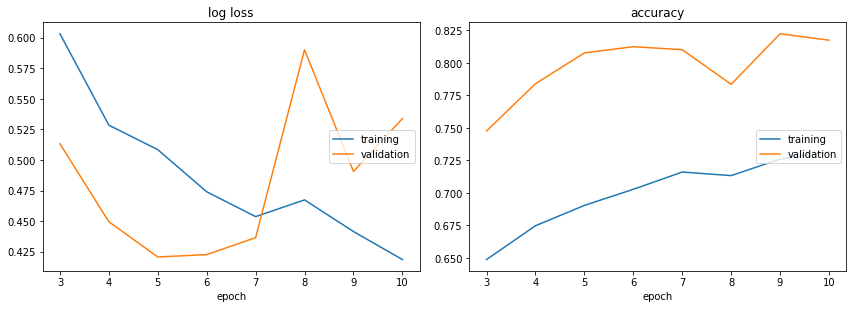

log loss:
training   (min:    0.419, max:    0.709, cur:    0.419)
validation (min:    0.421, max:    0.590, cur:    0.534)

accuracy:
training   (min:    0.570, max:    0.731, cur:    0.731)
validation (min:    0.720, max:    0.822, cur:    0.817)
Best model so far is epoch 9


In [12]:
model, best_model = train_model(model, criterion, optimizer, train_iter, 
                                valid_iter, num_epochs=10, save_dir='.')

### Model Testing

Load in the best model from the training based on the validation accuracy and evaluate on the testing set.

In [13]:
_, best_model, _, _ = load_best_model('.')
test_loss, test_accuracy = evaluate_model(model, test_iter)
print(f'Test Samples = {32*len(test_iter)}')
print(f'Test Accuracy = {test_accuracy:.3f}')

Test Samples = 25024
Test Accuracy = 0.814
